In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import copy
import shap
import pickle
import os

from scipy import linalg
from scipy.special import expit
from scipy import stats
from tqdm import tqdm
from matplotlib import cm
from sklearn.base import TransformerMixin, ClassifierMixin
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import (roc_auc_score, f1_score, precision_score, recall_score, 
                             RocCurveDisplay, PrecisionRecallDisplay)
from pandas.api.types import CategoricalDtype
from pyampute.exploration.md_patterns import mdPatterns

In [2]:
# Import libraries to interface with R
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from IPython.display import Image, display

In [3]:
# Load relevant R packages
base = importr("base")
rstats = importr("stats")
mice = importr("mice")
grdevices = importr("grDevices")

In [4]:
# Import MICE functions
from mice_functions import *

## Load incomplete dataset

In [5]:
# Data parameters
Ns = [20000, 10000, 5000, 2000, 1000]
mimic_dir = "../../data/mimic-iii/"
cat_cols = ["ETHNICITY", "MARITAL_STATUS"]
prefill_ed = True

# Load incomplete dataset
mimic_incomp = {}
for n in Ns:
    mimic_incomp[n] = pd.read_csv(mimic_dir + "processed{}.csv".format(n))

In [6]:
# Process binary and categorical variables
for n in Ns:
    # Reencode binary variables
    # Need to hard code as to avoid altering column name
    mimic_incomp[n]["INSURANCE"] = mimic_incomp[n]["INSURANCE"].map({
        "Government" : 0,
        "Private or Self Pay": 1
    })
    
    # Convert categorical columns in categorical format
    for c in cat_cols:
        mimic_incomp[n][c] = mimic_incomp[n][c].astype("category")
    
    # Rename some columns
    mimic_incomp[n] = mimic_incomp[n].rename(columns={
        "MARITAL_STATUS": "MARITALSTATUS",
        "ED_6HRS": "ED6HRS",
        "90DAYREADM": "READM90D"
    })
    
    if prefill_ed:
        mimic_incomp[n]["ED6HRS"] = mimic_incomp[n]["ED6HRS"].fillna(0)

Sample size = 20000



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


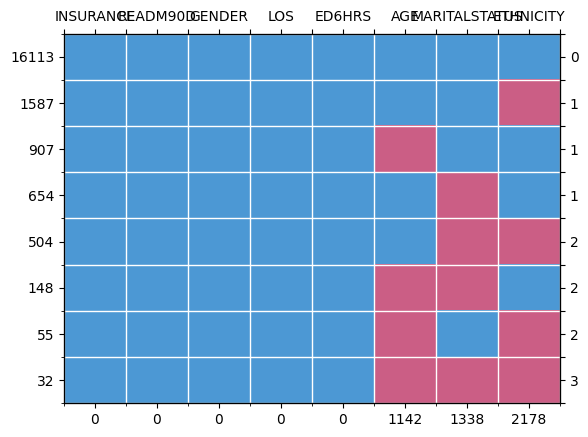

                         row_count  INSURANCE  READM90D  GENDER  LOS  ED6HRS  \
rows_no_missing              16113          1         1       1    1       1   
1                             1587          1         1       1    1       1   
2                              907          1         1       1    1       1   
3                              654          1         1       1    1       1   
4                              504          1         1       1    1       1   
5                              148          1         1       1    1       1   
6                               55          1         1       1    1       1   
7                               32          1         1       1    1       1   
n_missing_values_per_col                    0         0       0    0       0   

                           AGE  MARITALSTATUS  ETHNICITY  n_missing_values  
rows_no_missing              1              1          1                 0  
1                            1              1

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


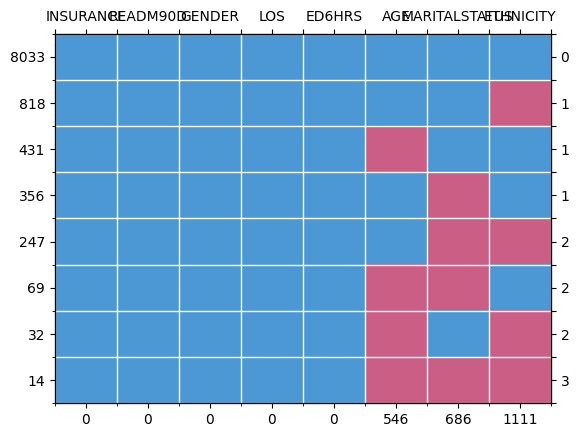

                         row_count  INSURANCE  READM90D  GENDER  LOS  ED6HRS  \
rows_no_missing               8033          1         1       1    1       1   
1                              818          1         1       1    1       1   
2                              431          1         1       1    1       1   
3                              356          1         1       1    1       1   
4                              247          1         1       1    1       1   
5                               69          1         1       1    1       1   
6                               32          1         1       1    1       1   
7                               14          1         1       1    1       1   
n_missing_values_per_col                    0         0       0    0       0   

                          AGE  MARITALSTATUS  ETHNICITY  n_missing_values  
rows_no_missing             1              1          1                 0  
1                           1              1   

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


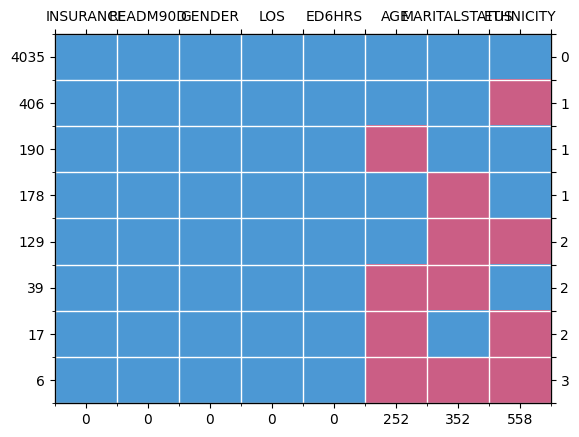

                         row_count  INSURANCE  READM90D  GENDER  LOS  ED6HRS  \
rows_no_missing               4035          1         1       1    1       1   
1                              406          1         1       1    1       1   
2                              190          1         1       1    1       1   
3                              178          1         1       1    1       1   
4                              129          1         1       1    1       1   
5                               39          1         1       1    1       1   
6                               17          1         1       1    1       1   
7                                6          1         1       1    1       1   
n_missing_values_per_col                    0         0       0    0       0   

                          AGE  MARITALSTATUS  ETHNICITY  n_missing_values  
rows_no_missing             1              1          1                 0  
1                           1              1   

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


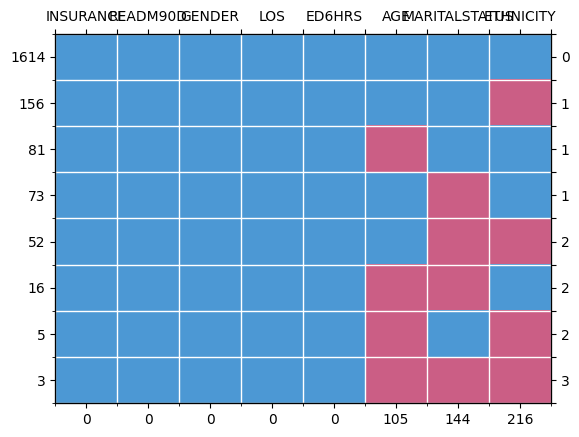

                         row_count  INSURANCE  READM90D  GENDER  LOS  ED6HRS  \
rows_no_missing               1614          1         1       1    1       1   
1                              156          1         1       1    1       1   
2                               81          1         1       1    1       1   
3                               73          1         1       1    1       1   
4                               52          1         1       1    1       1   
5                               16          1         1       1    1       1   
6                                5          1         1       1    1       1   
7                                3          1         1       1    1       1   
n_missing_values_per_col                    0         0       0    0       0   

                          AGE  MARITALSTATUS  ETHNICITY  n_missing_values  
rows_no_missing             1              1          1                 0  
1                           1              1   

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


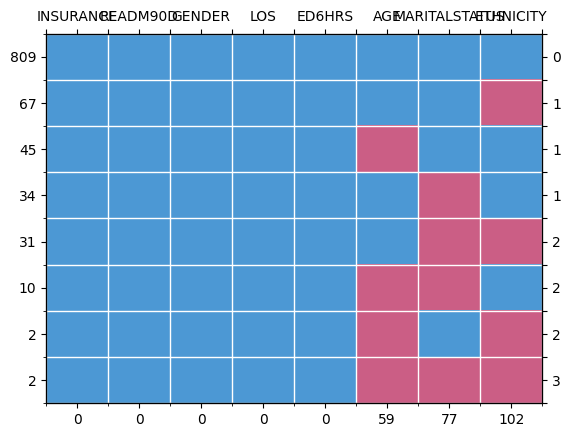

                         row_count  INSURANCE  READM90D  GENDER  LOS  ED6HRS  \
rows_no_missing                809          1         1       1    1       1   
1                               67          1         1       1    1       1   
2                               45          1         1       1    1       1   
3                               34          1         1       1    1       1   
4                               31          1         1       1    1       1   
5                               10          1         1       1    1       1   
6                                2          1         1       1    1       1   
7                                2          1         1       1    1       1   
n_missing_values_per_col                    0         0       0    0       0   

                          AGE  MARITALSTATUS  ETHNICITY  n_missing_values  
rows_no_missing             1              1          1                 0  
1                           1              1   

In [7]:
# Explore missing data patterns
for n in Ns:
    print(f"Sample size = {n}\n")
    print(mdPatterns().get_patterns(mimic_incomp[n]))
    print("\n\n")

In [8]:
# Convert data frames into R objects
mimic_incompr = {}
for n in Ns:
    with localconverter(robjects.default_converter + pandas2ri.converter):
        mimic_incompr[n] = robjects.conversion.py2rpy(mimic_incomp[n])

In [9]:
print(mimic_incompr[1000])

    INSURANCE ETHNICITY READM90D GENDER LOS ED6HRS        MARITALSTATUS AGE
0           0      <NA>        0      F   9      0 WIDOWED OR SEPARATED  86
1           0     WHITE        0      M   2      0               SINGLE  21
2           1     BLACK        0      M   4      0 WIDOWED OR SEPARATED  61
3           0     WHITE        0      M   2      0               SINGLE  78
4           0     BLACK        1      M  17      1            PARTNERED  80
5           0     WHITE        0      F   9      0 WIDOWED OR SEPARATED  85
6           0     WHITE        0      F   5      0            PARTNERED  75
7           0    OTHERS        0      F  11      0               SINGLE  48
8           0     ASIAN        0      M   5      0                 <NA>  69
9           1      <NA>        0      F   8      0                 <NA>  62
10          0     WHITE        0      M   5      1            PARTNERED  78
11          1     WHITE        0      F   4      1               SINGLE  53
12          

## Apply MICE algorithm

In [10]:
# Variables to be imputed
missingvars = ["ETHNICITY", "MARITALSTATUS", "AGE"]

# Select imputation models
# Create a placeholder MICE model to modify the method
temp_mice = mice.mice(mimic_incompr[Ns[0]], maxit=0, method="pmm", print=False)
with localconverter(robjects.default_converter + pandas2ri.converter):
    impmthd = robjects.conversion.rpy2py(temp_mice.rx2("method"))

# Add line here if any method is to be modified
#chas_idx = list(boston_incomp[10].columns).index("chas")
#bostonmthd[chas_idx] = "logreg.boot"
print(impmthd)

# Set number of imputations and maximum number of iterations
maxit = 40
m = 20

# Set number of donors for PMM
d = 10

# Set random seed
SEED = 2023

# Path to store any plots assessing convergence
conv_path = "../../results/figures/r_convergence_mimic_sens_V2/"
if not os.path.exists(conv_path):
    os.mkdir(conv_path)

    INSURANCE     ETHNICITY      READM90D        GENDER           LOS 
           ""         "pmm"            ""            ""            "" 
       ED6HRS MARITALSTATUS           AGE 
           ""         "pmm"         "pmm" 



In [11]:
# Prepare dictionary to store imputation objects from R
mimic_imputedr = {}

for n in tqdm(Ns):
    
    # Apply MICE algorithm
    mimic_imputedr[n] = mice.mice(mimic_incompr[n], m=m, maxit=maxit, method=impmthd, 
                                  seed=SEED, donors=d, print=False)
    
    # Construct trace plot
    #grdevices.pdf(file=conv_path + "traceplot_{}.pdf".format(n))
    #f = mice.plot_mids(mimic_imputedr[n])
    #base.print(f)
    #grdevices.dev_off()
    
    # Construct strip plots for imputed variables
    #for c in missingvars:
    #    # Set up image file
    #    grdevices.pdf(file=conv_path + "stripplot_{}_{}.pdf".format(c, n))
    #    # Create and print plot
    #    f = mice.stripplot_mids(mimic_imputedr[n], rstats.as_formula("{} ~ .imp".format(c)), 
    #                            pch=20, cex=2)
    #    base.print(f)
    #    # Close file
    #    grdevices.dev_off()
    

100%|█████████████████████████████████████████████| 5/5 [04:04<00:00, 48.89s/it]


In [12]:
# Convert to Python compatible format
# We need the imputed data and the missing flag

# Set up placeholder dictionary
mimic_imputed = {}

for n in tqdm(Ns):
    # Retrieve imputed data
    tempr = mice.complete_mids(mimic_imputedr[n], action="all", include=False)
    with localconverter(robjects.default_converter + pandas2ri.converter):
        temp = robjects.conversion.rpy2py(tempr)
    # Note that reset_index is necessary as R had converted all indices to strings
    mimic_imputed[n] = {"imp": [v.reset_index(drop=True) for k, v in temp.items()]}
    
    # Construct missing flag using the original data
    mimic_imputed[n]["missingflag"] = mimic_incomp[n].isna()
    
    # Retrieve chain statistics
    # NOTE: Here, the variance is retrieved instead of standard deviations
    with localconverter(robjects.default_converter + pandas2ri.converter):
        tempchainmu = robjects.conversion.rpy2py(mimic_imputedr[n].rx2("chainMean"))
        tempchainsig = robjects.conversion.rpy2py(mimic_imputedr[n].rx2("chainVar"))
    mimic_imputed[n]["chainmean"] = tempchainmu
    with np.errstate(invalid="ignore"): # suppress warnings for the NAs
        mimic_imputed[n]["chainstd"] = np.sqrt(tempchainsig)
    
    # Include maxit
    mimic_imputed[n]["maxit"] = maxit

100%|█████████████████████████████████████████████| 5/5 [00:10<00:00,  2.01s/it]


In [13]:
# Prevent plots from being printed
%matplotlib agg

# Construct trace plot and strip plot
for n in tqdm(Ns):
    # Create and save trace plot
    f = ChainStatsViz(mimic_imputed[n], missingvars=missingvars)
    f.savefig(conv_path + "traceplot_{}.pdf".format(n), dpi=300)
    
    # Create and save strip plot
    for c in missingvars:
        f = plotImputedData(mimic_imputed[n], c)
        f.savefig(conv_path + "{}_stripplot_{}.pdf".format(c, n), dpi=300)

100%|█████████████████████████████████████████████| 5/5 [02:56<00:00, 35.25s/it]


In [14]:
# Save multiply imputed data as Python objects
file_suffix = ("_sens" if prefill_ed else "")
with open(mimic_dir + "imputed_r{}.pickle".format(file_suffix), "wb") as handle:
    pickle.dump(mimic_imputed, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Apply complete case analysis

In [15]:
# Prepare dictionary to store complete case data
mimic_cc = {}

for n in tqdm(Ns):
    # Apply complete case analysis on each dataset
    mimic_cc[n] = mimic_incomp[n].dropna()
    print("Original sample size = {}. Dimension of complete case data = {}".format(
        n, mimic_cc[n].shape))

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 356.94it/s]

Original sample size = 20000. Dimension of complete case data = (16113, 8)
Original sample size = 10000. Dimension of complete case data = (8033, 8)
Original sample size = 5000. Dimension of complete case data = (4035, 8)
Original sample size = 2000. Dimension of complete case data = (1614, 8)
Original sample size = 1000. Dimension of complete case data = (809, 8)


In [16]:
# Store complete case data
for n in Ns:
    mimic_cc[n].to_csv(mimic_dir + "complete_case_{}{}.csv".format(n, file_suffix), 
                        index=False)